In [1]:
import math
import random
from collections import namedtuple, deque

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
import matplotlib.pyplot as plt

USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

In [2]:
class StochasticMDP:
    def __init__(self):
        self.end           = False
        self.current_state = 2
        self.num_actions   = 2
        self.num_states    = 6
        self.p_right       = 0.5

    def reset(self):
        self.end = False
        self.current_state = 2
        state = np.zeros(self.num_states)
        state[self.current_state - 1] = 1.
        return state

    def step(self, action):
        if self.current_state != 1:
            if action == 1:
                if random.random() < self.p_right and self.current_state < self.num_states:
                    self.current_state += 1
                else:
                    self.current_state -= 1
                    
            if action == 0:
                self.current_state -= 1
                
            if self.current_state == self.num_states:
                self.end = True
        
        state = np.zeros(self.num_states)
        state[self.current_state - 1] = 1.
        
        if self.current_state == 1:
            if self.end:
                return state, 1.00, True, {}
            else:
                return state, 1.00/100.00, True, {}
        else:
            return state, 0.0, False, {}

In [6]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer   = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [3]:
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(num_inputs, 256),
            nn.ReLU(),
            nn.Linear(256, num_outputs)
        )
    
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state  = torch.FloatTensor(state).unsqueeze(0)
            action = self.forward(Variable(state, volatile=True)).max(1)[1]
            return action.data[0]
        else:
            return random.randrange(num_actions)

In [9]:
env = StochasticMDP()
num_goals    = env.num_states
num_actions  = env.num_actions

model        = Net(2*num_goals, num_actions)
target_model = Net(2*num_goals, num_actions)

meta_model        = Net(num_goals, num_goals)
target_meta_model = Net(num_goals, num_goals)

if USE_CUDA:
    model             = model.cuda()
    target_model      = target_model.cuda()
    meta_model        = meta_model.cuda()
    target_meta_model = target_meta_model.cuda()

optimizer      = optim.Adam(model.parameters())
meta_optimizer = optim.Adam(meta_model.parameters())

replay_buffer      = ReplayBuffer(10000)
meta_replay_buffer = ReplayBuffer(10000)

In [10]:
def to_onehot(x):
    oh = np.zeros(6)
    oh[x - 1] = 1.
    return oh

def update(model, optimizer, replay_buffer, batch_size):
    if batch_size > len(replay_buffer):
        return
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    
    state      = Variable(torch.FloatTensor(state))
    next_state = Variable(torch.FloatTensor(next_state), volatile=True)
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))
    
    q_value = model(state)
    q_value = q_value.gather(1, action.unsqueeze(1)).squeeze(1)
    
    next_q_value     = model(next_state).max(1)[0]
    expected_q_value = reward + 0.99 * next_q_value * (1 - done)
   
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.detach().cpu().numpy()

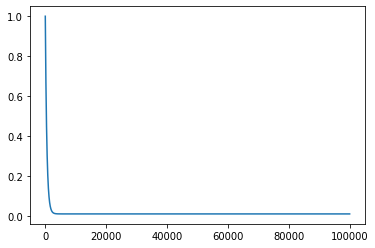

In [12]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)
plt.figure()
plt.plot([epsilon_by_frame(i) for i in range(100000)])

In [15]:
num_frames = 100000
frame_idx  = 1

state = env.reset()
print(state.shape)
done = False
all_rewards = []
avg_rewards = []
model_losses = []
meta_losses = []
episode_reward = 0
avg_reward = 0

while frame_idx < num_frames:
    goal = meta_model.act(state, epsilon_by_frame(frame_idx))
    onehot_goal  = to_onehot(goal)
    
    meta_state = state
    extrinsic_reward = 0
    
    while not done and goal != np.argmax(state):
        goal_state  = np.concatenate([state, onehot_goal])
        action = model.act(goal_state, epsilon_by_frame(frame_idx))
        next_state, reward, done, _ = env.step(action)

        episode_reward   += reward
        extrinsic_reward += reward
        intrinsic_reward = 1.0 if goal == np.argmax(next_state) else 0.0

        replay_buffer.push(goal_state, action, intrinsic_reward, np.concatenate([next_state, onehot_goal]), done)
        state = next_state
        
        model_loss = update(model, optimizer, replay_buffer, 32)
        meta_loss = update(meta_model, meta_optimizer, meta_replay_buffer, 32)
        frame_idx += 1
        
        if frame_idx % 1000 == 0:
            avg_reward = np.mean(all_rewards[-1000:])
            print('Step-',frame_idx,'/',num_frames,'|','Loss-',model_loss,'|','Reward-',extrinsic_reward)
            
    meta_replay_buffer.push(meta_state, goal, extrinsic_reward, state, done)
        
    if done:
        state = env.reset()
        done  = False
        all_rewards.append(episode_reward)
        avg_rewards.append(avg_reward)
        model_losses.append(model_loss)
        meta_losses.append(meta_loss)
        episode_reward = 0

(6,)


K:\Users\Karush Suri\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  app.launch_new_instance()


Step- 1000 / 100000 | Loss- 0.09946685 | Reward- 0.01
Step- 2000 / 100000 | Loss- 0.059294783 | Reward- 0.0
Step- 3000 / 100000 | Loss- 0.05081391 | Reward- 0.01
Step- 4000 / 100000 | Loss- 0.04464238 | Reward- 0.01
Step- 5000 / 100000 | Loss- 0.07054983 | Reward- 0.0
Step- 6000 / 100000 | Loss- 0.0952085 | Reward- 0.0
Step- 7000 / 100000 | Loss- 0.07500065 | Reward- 0.0
Step- 8000 / 100000 | Loss- 0.09040792 | Reward- 0.01
Step- 9000 / 100000 | Loss- 0.13388234 | Reward- 0.0
Step- 10000 / 100000 | Loss- 0.15049233 | Reward- 0.01
Step- 11000 / 100000 | Loss- 0.1532603 | Reward- 0.0
Step- 12000 / 100000 | Loss- 0.10369633 | Reward- 0.0
Step- 13000 / 100000 | Loss- 0.024184747 | Reward- 0.01
Step- 14000 / 100000 | Loss- 0.032284737 | Reward- 0.0
Step- 15000 / 100000 | Loss- 0.05917393 | Reward- 0.0
Step- 16000 / 100000 | Loss- 0.04309781 | Reward- 0.0
Step- 17000 / 100000 | Loss- 0.04676676 | Reward- 0.0
Step- 18000 / 100000 | Loss- 0.06658832 | Reward- 0.0
Step- 19000 / 100000 | Loss- 0

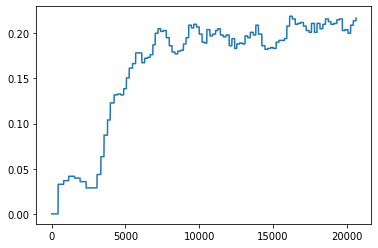

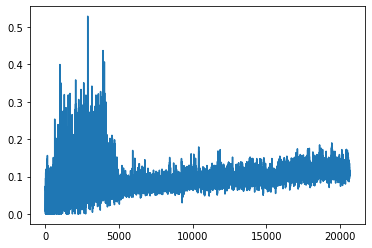

In [16]:
plt.figure()
plt.plot(avg_rewards)
plt.figure()
plt.plot(model_losses)